In [1]:
"""
Follows https://www.tensorflow.org/tutorials/text/text_classification_rnn
"""
import pickle as pkl
import numpy as np
import random
import re

import tensorflow_datasets as tfds
import tensorflow as tf

import matplotlib.pyplot as plt

In [2]:
from datetime import datetime
datetime.now()

datetime.datetime(2020, 12, 17, 2, 5, 25, 547120)

In [3]:
def plot_graphs(history, metric):
    fig, ax1 = plt.subplots()

    color = 'tab:red'
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel(metric, color=color)
    ax1.plot(history.history[metric], color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel("val_" + metric, color=color)  # we already handled the x-label with ax1
    ax2.plot(history.history["val_" + metric], color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.legend([metric, "val_" + metric])


In [4]:
def split_data_into_input_and_output(data):
    """Take given data of format from scraper [link] and return the inputs and outputs seperated.

    Args:
        data (list): A numpy array/list of named tuples which contains entries for 'gross',
        'title', 'synopsis' and 'year'.
    """
    data_in, data_out = list(zip(*[((x["synopsis"]), x["gross"]) for x in data]))
    return np.array(data_in), np.array(data_out)

In [5]:
def add_signal(data):
    """
    If the given data has no signal we cant fit a NN to it. As such, here we append how much the film grossed
    into the synopsis of each title.

    Args:
        data (list): A numpy array/list of named tuples which contains entries for 'gross',
        'title', 'synopsis' and 'year'.
    """
    for row in data:
        row["synopsis"] = row["synopsis"] + f' The film grossed ${row["gross"]}'

In [6]:
real_data = pkl.load(open("complete10000_films_and_synopsis.pickle", "rb"))
np.random.shuffle(real_data[500:])
data = real_data

In [7]:
# Fraction of overall data
training_fraction = 0.1

train_end = int(len(data) * training_fraction)
train_data_in, train_data_out = split_data_into_input_and_output(data[:train_end])
test_data_in, test_data_out = split_data_into_input_and_output(data[train_end:])

train_dataset = tf.data.Dataset.from_tensor_slices((train_data_in, train_data_out))
test_dataset = tf.data.Dataset.from_tensor_slices((test_data_in, test_data_out))


# How much it loads into memory for sampling
BUFFER_SIZE = 10000
# Batch for gradient averaging
BATCH_SIZE = 64
# prefetch parrallelising loading + execution (not huge so not necessary)

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(5)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(5)

In [8]:
sample, label = next(iter(train_dataset.take(1)))

In [9]:
VOCAB_SIZE = 10000
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=VOCAB_SIZE, ngrams=1
)


In [10]:
encoder.adapt(train_dataset.map(lambda text, label: text))

In [11]:
encoded_sample = encoder(sample).numpy()[:3]
print(encoded_sample)

[[   2 5324    5    3 2082 2572 2575  814    6  402 2373  403   21 2329
  1829  619  292  921   52    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0]
 [   2 1246  509    2   31  259   44 1003   19  323    6 2542  874    8
    65  320   29    2 1017  864    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0]
 [   2 3133  542  146    4  495   13    3 5890  688  246   19   38    9
   142    4  239   79    7   10   12  115    4  811 2837    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0]]


In [12]:
vocab = np.array(encoder.get_vocabulary())

for n in range(3):
  print("Original: ", sample[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_sample[n]]))
  print()

Original:  b'A dramatization of the July 20, 1944 assassination and political coup plot by desperate renegade German Army officers against '
Round-trip:  a dramatization of the july 20 1944 assassination and political coup plot by desperate renegade german army officers against                       

Original:  b'A musician helps a young singer find fame as age and alcoholism send his own career into a downward spiral.'
Round-trip:  a musician helps a young singer find fame as age and alcoholism send his own career into a downward spiral                      

Original:  b'A substance-addicted actress tries to look on the bright side even as she is forced to move back in with her mother to avoid unemployment.'
Round-trip:  a substanceaddicted actress tries to look on the bright side even as she is forced to move back in with her mother to avoid unemployment                 



In [13]:
model = tf.keras.Sequential(
    [
        encoder,
        tf.keras.layers.Embedding(
            input_dim=len(encoder.get_vocabulary()), output_dim=64, mask_zero=True
        ),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(1),
    ]
)

model.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer=tf.keras.optimizers.Adam(0.1),
)

In [14]:
history = model.fit(
    train_dataset, epochs=100, validation_data=test_dataset, validation_steps=len(test_data_in) // BATCH_SIZE
)

Epoch 1/100
16/16 [==============================] - 15s 914ms/step - loss: 31662992827351040.0000 - val_loss: 1090823915569152.0000
Epoch 2/100
16/16 [==============================] - 11s 668ms/step - loss: 31298251319672832.0000 - val_loss: 955429433638912.0000
Epoch 3/100
16/16 [==============================] - 10s 630ms/step - loss: 29326816233652224.0000 - val_loss: 714842612695040.0000
Epoch 4/100
16/16 [==============================] - 10s 656ms/step - loss: 23855659258740736.0000 - val_loss: 3015718266208256.0000
Epoch 5/100
16/16 [==============================] - 10s 642ms/step - loss: 17402364596060160.0000 - val_loss: 10536347198554112.0000
Epoch 6/100
16/16 [==============================] - 11s 663ms/step - loss: 13818116677042176.0000 - val_loss: 10304328770256896.0000
Epoch 7/100
16/16 [==============================] - 10s 656ms/step - loss: 9892274976587776.0000 - val_loss: 14045891677650944.0000
Epoch 8/100
16/16 [==============================] - 10s 644ms/step -

In [15]:
res = model.evaluate(test_dataset)

141/141 [==============================] - 9s 61ms/step - loss: 48062565237915648.0000


In [16]:
sample_text = "As a new threat to the galaxy rises, Rey, a desert scavenger, and Finn, an ex-stormtrooper, must join Han Solo and Chewbacca to search for the one hope of restoring peace."
pred1 = model.predict(np.array([sample_text]))
print(int(pred1[0]))

532070496


In [17]:
non_existant_film = "Este is a friend of mine we meet up every tuesday night for dinner and a glass of wine. She thinks he did it but just cant prove it"
pred2 = model.predict(np.array([non_existant_film]))
print(int(pred2[0]))

418226912


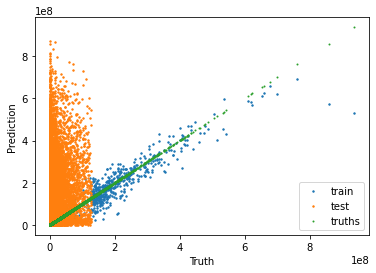

In [18]:
test_predictions = model.predict(test_data_in)
train_predictions = model.predict(train_data_in)
plt.scatter(train_data_out, train_predictions, label='train', s=2)
plt.scatter(test_data_out, test_predictions, label='test', s=2)
plt.scatter(real_data['gross'], real_data['gross'], label='truths', s=1)
plt.legend()
plt.xlabel('Truth')
plt.ylabel('Prediction')
plt.show()
plt.savefig("exp_13.pdf", dpi=300)

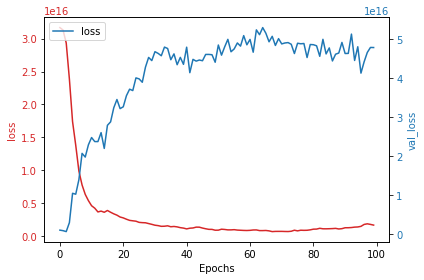

In [19]:
plot_graphs(history,'loss')
plt.savefig("exp_13_2.pdf", dpi=300)

In [ ]:
import pickle as pkl
pkl.dump(history, open('exp_13.pkl','wb'))